## 라이브러리 임포트

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기 (학습데이터 ,테스트 데이터)
- 데이터 분석단계에서 생성한 농구 선수 포지션 예측하기의 학습 데이터 및 테스터 데이터 로드.

In [3]:
train = pd.read_csv('data/csv/basketball_train.csv')
test = pd.read_csv('data/csv/basketball_test.csv')

## SVM 최적의 파라미터값 찾기
- 1. C(cost, 비용) : 결정경계선의 마진을 결정하는 파라미터
- 2. gamma(감마) : RBF 커널을 사용할 때, 커널의 데이터포인트의 표준편차를 결정하는 파라미터.

### sklearn에서 제공하는 GridSearchCV 사용하시면, 손쉽게 최적의 c, gamma를 구할 수 있다.

In [34]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC  #svm 알고리즘 모듈
from sklearn.metrics import classification_report #분류와 관련된 알고리즘 레포트
from sklearn.metrics import accuracy_score

In [5]:
def svc_param_selection(X, y, nfolds): #y는 1차원 배열로 
    svm_parameters = [
        {
            'kernel' : ['rbf'],
            'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
            'C' : [0.01, 0.1, 1, 10, 100, 1000]
        }
    ]
    
    clf = GridSearchCV(SVC(), svm_parameters, cv = nfolds) # 최적의 감마와 c값을 계산해줌 #nfolds : kfold
    clf.fit(X, y) #fit: 학습값 제공 메서드  
    print(clf.best_params_) #best_params_ : 최적의 gamma와 c값 
    
    return clf

In [6]:
X_train = train[['3P','BLK']]
y_train = train[['Pos']]

#최적의 파라미터는 sklearn의 GridSearchCV()를 통해 구한다.
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


## 시각화
- 최적의 파라미터일때의 결정결계선과 다른 파라미터들일 때의 결정경계선 비교

In [14]:
#시각화를 하기위해, 최적의 C와 다른 C를 후보로 저장

C_candidaties = []
C_candidaties.append(clf.best_params_['C'] * 0.01)
C_candidaties.append(clf.best_params_['C'])  #append() 괄호안 데이터 추가
C_candidaties.append(clf.best_params_['C'] * 100)

#시각화를 하기위해, 최적의 gamma와 다른 gamma를 후보로 저장

gamma_candidaties = []
gamma_candidaties.append(clf.best_params_['gamma'] * 0.01)
gamma_candidaties.append(clf.best_params_['gamma'])
gamma_candidaties.append(clf.best_params_['gamma'] * 100)

In [21]:
X = train[['3P','BLK']]
Y = train['Pos'].tolist()
#시리즈 -> 리스트로 변환
#포지션에 해당하는 문자열 'SG'와 'C'를 벡터화 한다.
position = []
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)   #문자열 데이터를 숫자값으로 변환

In [22]:
## 각각의 파라미터에 해당하는 SVM 모델을 만들어 classifiers에 저장 한다.
classifiers = []
for C in C_candidaties:
    for gamma in gamma_candidaties:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))

C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names


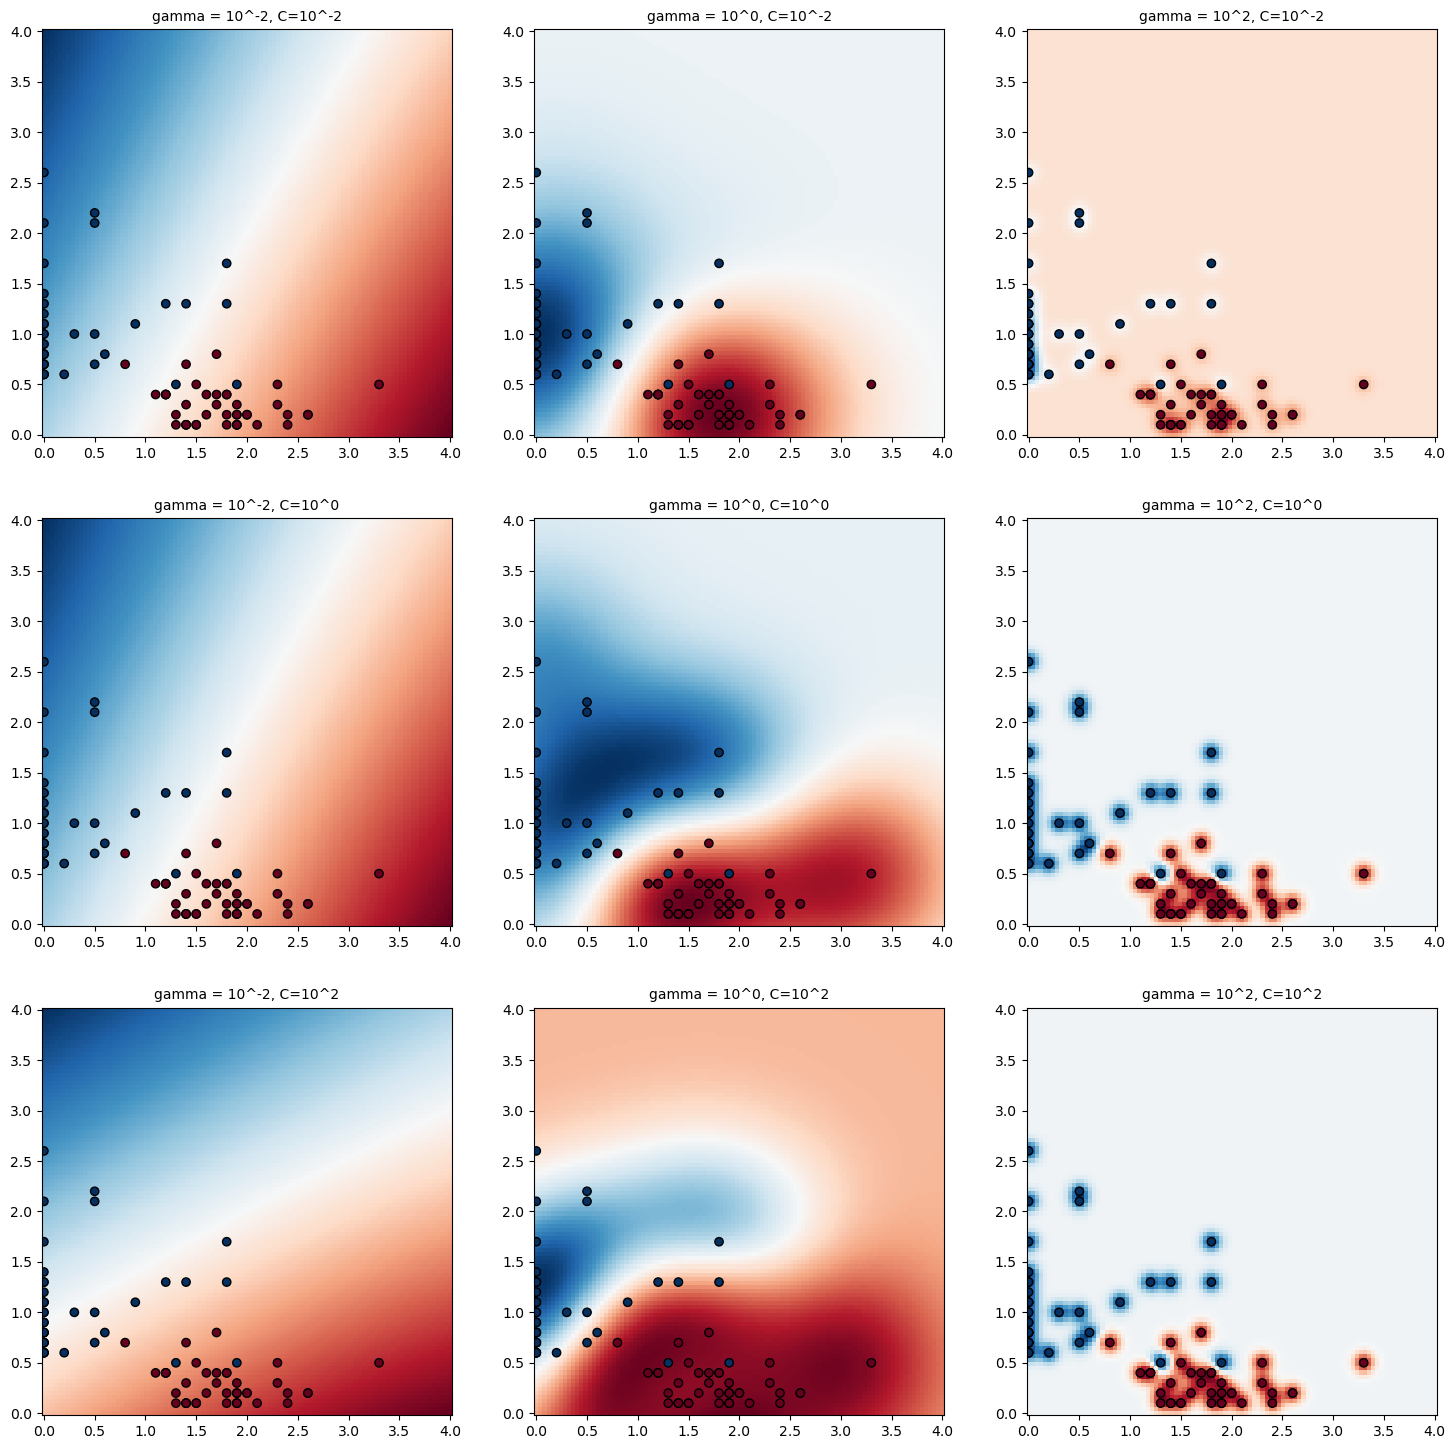

In [28]:
# 18 x 18 사이즈의 차트 구성
plt.figure(figsize=(18,18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100)) #linspace(시작, 마지막, 간격)

#각각의 모델들에 대한 결정 경계 함수를 적용하여 함께 시각화
for(k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 최적의 모델을 파라미터로 학습된 모델들을 함께 시각화
    plt.subplot(len(C_candidaties), len(gamma_candidaties), k+1)
    plt.title("gamma = 10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size ='medium')
    
    plt.pcolormesh(xx, yy, -Z, cmap = plt.cm.RdBu)
    plt.scatter(X['3P'],X['BLK'], c = position, cmap = plt.cm.RdBu_r, edgecolors = 'k')

In [20]:
test_x, test_y = np.meshgrid([1, 2, 3],[1, 2, 3])
print(test_x)
print(test_y)

[[1 2 3]
 [1 2 3]
 [1 2 3]]
[[1 1 1]
 [2 2 2]
 [3 3 3]]


## 테스트
- sklearn의 gridsearch로 얻어진 최적의 파라미터로 학습된 clf를 이용하여, 

In [35]:
# 테스트에 사용될 특징을 지정
X_test = test[['3P', 'BLK']]

# 특징으로 예측할 값(농구선수 포지션)을 지정
y_test = test[['Pos']]

# 최적의 파라미터로 완성된 SVM에 테스트 데이터를 주입하여, 실제값과 예측값을 얻는다.
y_true, y_pred = y_test, clf.predict(X_test) #predict 예측 fit 학습

print(classification_report(y_true, y_pred))
print('accuracy : ' + str(accuracy_score(y_true, y_pred)))

              precision    recall  f1-score   support

           C       0.80      0.80      0.80        10
          SG       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20

accuracy : 0.8


In [37]:
comparision = pd.DataFrame({'prediction':y_pred, 'target': y_test.values.ravel()})
comparision

,prediction,target
0,SG,C
1,SG,SG
2,C,C
3,SG,SG
4,C,SG
5,SG,SG
6,SG,SG
7,SG,SG
8,C,C
9,C,C
